In [1]:
# Author and date
import datetime, getpass
user = getpass.getuser()
print(user, datetime.datetime.today())

ubuntu 2021-03-04 01:24:41.809072


In [2]:
%matplotlib inline
from ipywidgets import Image
from matplotlib import pyplot as plt

import datajoint as dj

In [3]:
schema = dj.schema(f'states')

Connecting root@127.0.0.1:3306


In [4]:
states = dict(
    AL='Alabama',        AK='Alaska',       AZ='Arizona',      AR='Arkansas',
    CA='California',     CO='Colorado',     CT='Connecticut',  DE='Delaware',
    FL='Florida',        GA='Georgia',      HI='Hawaii',       ID='Idaho', 
    IL='Illinois',       IN='Indiana',      IA='Iowa',         KS='Kansas',
    KY='Kentucky',       LA='Louisiana',    ME='Maine',        MD='Maryland',
    MA='Massachusetts',  MI='Michigan',     MN='Minnesota',    MS='Mississippi',
    MO='Missouri',       MT='Montana',      NE='Nebraska',     NV='Nevada',
    NH='New Hampshire',  NJ='New Jersey',   NM='New Mexico',   NY='New York',
    NC='North Carolina', ND='North Dakota', OH='Ohio',         OK='Oklahoma',
    OR='Oregon',         PA='Pennsylvania', RI='Rhode Island', SC='South Carolina',
    SD='South Dakota',   TN='Tennessee',    TX='Texas',        UT='Utah',
    VT='Vermont',        VA='Virginia',     WA='Washington',   WV='West Virginia', 
    WI='Wisconsin',      WY='Wyoming')

In [5]:
@schema
class State(dj.Lookup):
    definition = """
    # United States
    state_code : char(2)
    ---
    state : varchar(20)
    """
    contents = states.items()

In [6]:
State()

state_code,state
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut
DE,Delaware
FL,Florida
GA,Georgia


In [7]:
form = {'state': 'newyork'}
Image.from_url("http://www.theus50.com/images/state-birds/{state}-bird.jpg".format(**form))

AttributeError: type object 'Image' has no attribute 'from_url'

In [ ]:
Image.from_url("http://www.theus50.com/images/state-flags/{state}-flag.jpg".format(**form))

In [ ]:
Image.from_url("http://www.theus50.com/images/state-flowers/{state}-flower.jpg".format(**form))

In [9]:
import requests

@schema
class StateBird(dj.Imported):
    definition = """
    -> State
    ---
    bird_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-birds/{state}-bird.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, bird_image=plt.imread(temp_file)))

In [11]:
StateBird().populate(display_progress=True, suppress_errors=True)

0it [00:00, ?it/s]


[]

In [16]:
import requests

@schema
class StateFlag(dj.Imported):
    definition = """
    -> State
    ---
    flag_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-flags/{state}-flag.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flag_image=plt.imread(temp_file)))

In [17]:
StateFlag.populate(display_progress=True)

100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


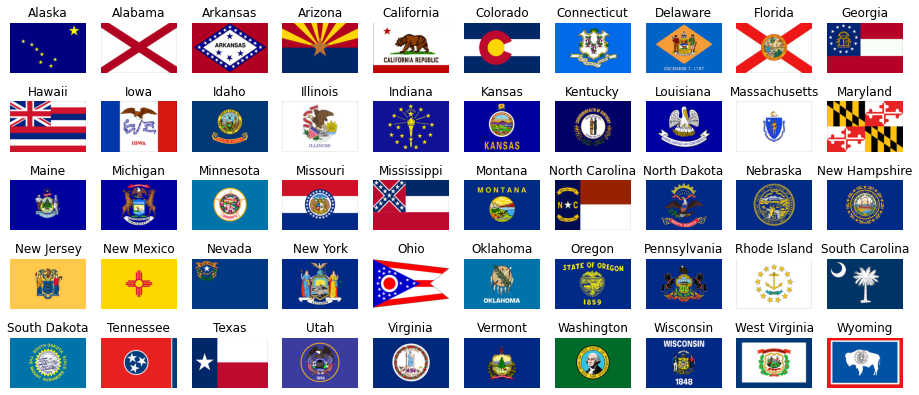

In [18]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State).fetch(as_dict=True)):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

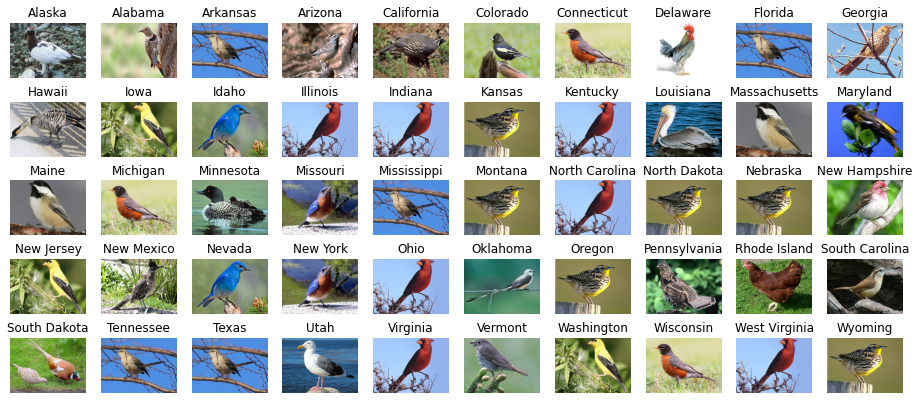

In [19]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateBird*State).fetch(as_dict=True)):
    ax.imshow(info['bird_image'])
    ax.set_title(info['state'])
    ax.axis(False)

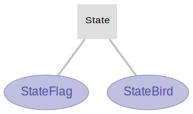

In [20]:
dj.Diagram(schema)